In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
def get_ref_test_imgs(data_root, class_name, ref_idx=0):
    img_paths = [str(img_path) for img_path in data_root.glob(f'{class_name}/*.jpg')]
    ref_path = img_paths.pop(ref_idx)

    test_imgs = [
        cv2.imread(img_path)[..., ::-1]
        for img_path in img_paths
    ]

    ref_img = cv2.imread(ref_path)[..., ::-1]

    return ref_img, test_imgs

In [3]:
def get_white_mask(img, mask_threshold=240):
    one_channel_mask = np.where(np.all(img > mask_threshold, axis=-1), 0, 255)
    # np.repeat(one_channel_mask[..., None], 3, axis=-1).astype(np.uint8)
    return one_channel_mask.astype(np.uint8)

def calc_hs_hist(img, mask=None):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    ranges = [0, 180,
              0, 256]

    channels = [0,
                1]

    histSize = [180,
                256]

    hist = cv2.calcHist([img], channels, mask, histSize, ranges, accumulate=False)
    cv2.normalize(hist, hist, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    return hist

In [4]:
data_root = Path('data/coca_vs_pepsi/')

coca_ref_img, coca_test_imgs = get_ref_test_imgs(data_root, 'CocaCola2L', ref_idx=1)
pepsi_ref_img, pepsi_test_imgs = get_ref_test_imgs(data_root, 'Pepsi2L', ref_idx=1)
fanta_ref_img, fanta_test_imgs = get_ref_test_imgs(data_root, 'Fanta2L', ref_idx=1)
sprite_ref_img, sprite_test_imgs = get_ref_test_imgs(data_root, 'Sprite2L', ref_idx=1)

test_imgs = [*coca_test_imgs, *fanta_test_imgs, *pepsi_test_imgs, *sprite_test_imgs]
ref_imgs = {
    'coca': coca_ref_img,
    'fanta': fanta_ref_img,
    'pepsi': pepsi_ref_img,
    'sprite': sprite_ref_img,
}

colors = {
    'coca': 'red',
    'fanta': 'orange',
    'pepsi': 'blue',
    'sprite': 'green',
}

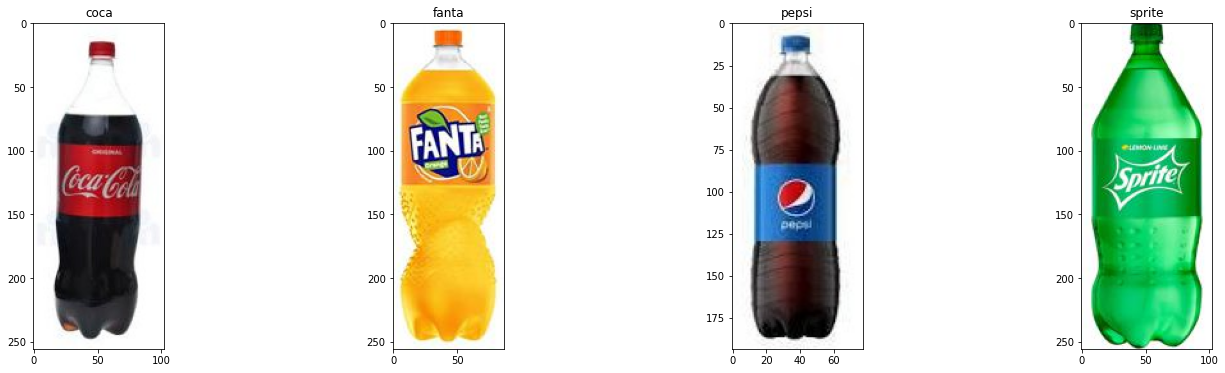

In [5]:
ncols = len(ref_imgs)

fig, axes = plt.subplots(ncols=ncols, figsize=(6*ncols, 6))

for i, (label, ref_img) in enumerate(ref_imgs.items()):
    axes[i].set_title(label)
    axes[i].imshow(ref_img)

In [6]:
ref_hists = {
    label: calc_hs_hist(img, get_white_mask(img))
    for label, img in ref_imgs.items()
}

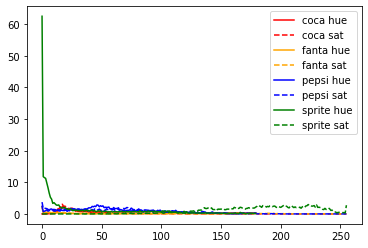

In [8]:
for label, hist in ref_hists.items():
    plt.plot(hist.sum(axis=1), label=f'{label} hue', color=colors[label], linestyle='-')
    plt.plot(hist.sum(axis=0), label=f'{label} sat', color=colors[label], linestyle='--')
plt.legend()

In [9]:
# Correlation: MAX
# Chi-square: MIN
# Intersection: MAX
# Bhattacharyya: MIN

compare_method = cv2.HISTCMP_CORREL
arg_best = max

results = []

for test_img in test_imgs:
    test_hist = calc_hs_hist(test_img, get_white_mask(test_img))

    results.append({
        label: cv2.compareHist(ref_hist, test_hist, compare_method)
        for label, ref_hist in ref_hists.items()
    })

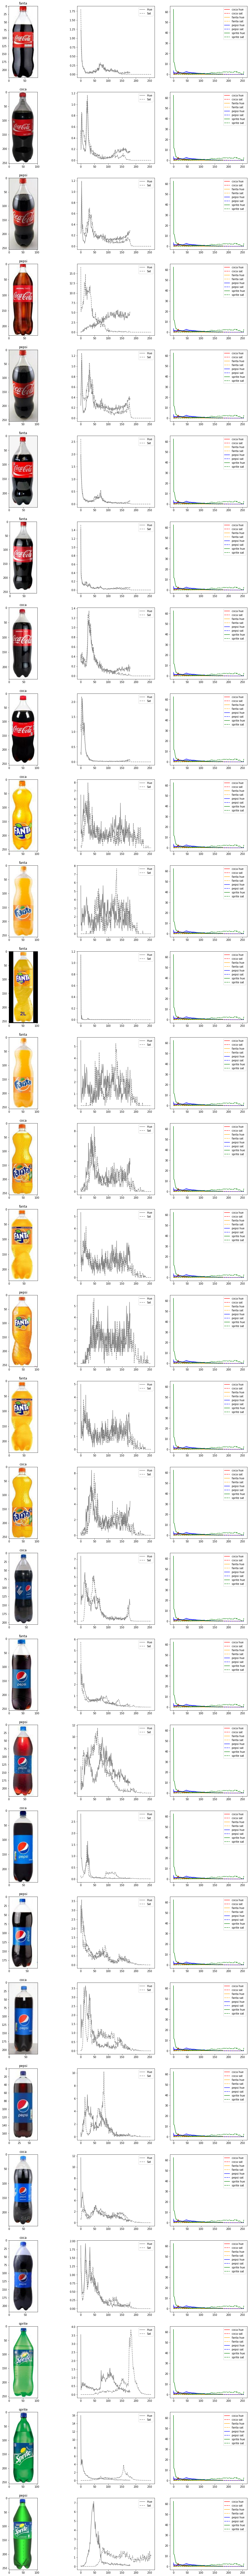

In [10]:
ncols = 3
nrows = len(test_imgs)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 6*nrows))

for i, (img, result) in enumerate(zip(test_imgs, results)):
    text = arg_best(result, key=result.get)

    axes[i][0].set_title(text)
    axes[i][0].imshow(img)

    test_hist = calc_hs_hist(img)

    axes[i][1].plot(test_hist.sum(axis=1), label=f'Hue', color='gray', linestyle='-')
    axes[i][1].plot(test_hist.sum(axis=0), label=f'Sat', color='gray', linestyle='--')
    axes[i][1].legend()

    for label, ref_hist in ref_hists.items():
        axes[i][2].plot(ref_hist.sum(axis=1), label=f'{label} hue',
                        color=colors[label], linestyle='-')
        axes[i][2].plot(ref_hist.sum(axis=0), label=f'{label} sat',
                        color=colors[label], linestyle='--')

    axes[i][2].legend()

-0.01694915254237288

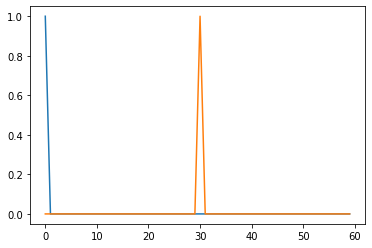

In [11]:
dummy_hist_1 = np.zeros((1, 60), dtype=np.float32)
dummy_hist_1[0][0] = 1
dummy_hist_1 = cv2.normalize(dummy_hist_1, dummy_hist_1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

dummy_hist_2 = np.zeros((1, 60), dtype=np.float32)
dummy_hist_2[0][30] = 1
dummy_hist_2 = cv2.normalize(dummy_hist_2, dummy_hist_2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

plt.plot(dummy_hist_1[0])
plt.plot(dummy_hist_2[0])

cv2.compareHist(dummy_hist_1, dummy_hist_2, compare_method)